<b> Projekt leírás <b>

Szeretnék egy modellt építeni Google StreetView adatokra alapozva, ami képes megmondani más StreetView képekről, hogy hol készültek. A projektet a GeoGuessr inspirálta, ami egy online játék, amelyben a játékosok különböző streetview térképeken navigálnak, és megpróbálják kitalálni a látott képek helyét.

A modell betanításához már összegyűjtöttem 25 000 képet, amiknek egy része a Google StreetVies API-val kerültek kinyerésre, egy részük pedig a GeoGuessr játékban készültek. 

A notebookban kiplotoltam, hogy hogyan oszlanak meg a képek. A képek eloszlása egyáltalán nem egyenletes, de ez magában a játékban sincs így, hiszen nagyban befolyásolja, hogy az egyes országokat milyen mértékben fedi le a Google StreetView. 



In [299]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import cv2
from shapely.geometry import Point, box
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

Map pictures

In [251]:
coord = pd.read_csv('C:/Users/Márk/Desktop/Machine Learning/projekt/Streetview_Image_Dataset/coordinates.csv')

In [253]:
# load worldmap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# create points using coordinates
geometry = [Point(xy) for xy in zip(coord['longitude'], coord['latitude'])]
geo_df = gpd.GeoDataFrame(coord, geometry=geometry)

# join with countries
geo_df = gpd.sjoin(geo_df, world, how="left", op='within')

# keep only relevant columns
geo_df = geo_df[['latitude', 'longitude', 'name']]

# rename name to country
geo_df = geo_df.rename(columns={'name': 'country'})

# save to csv
geo_df.to_csv('coord_with_countries.csv', index=False)

C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\3475004758.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\Márk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\3475004758.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4

Plot

C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\2738065404.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


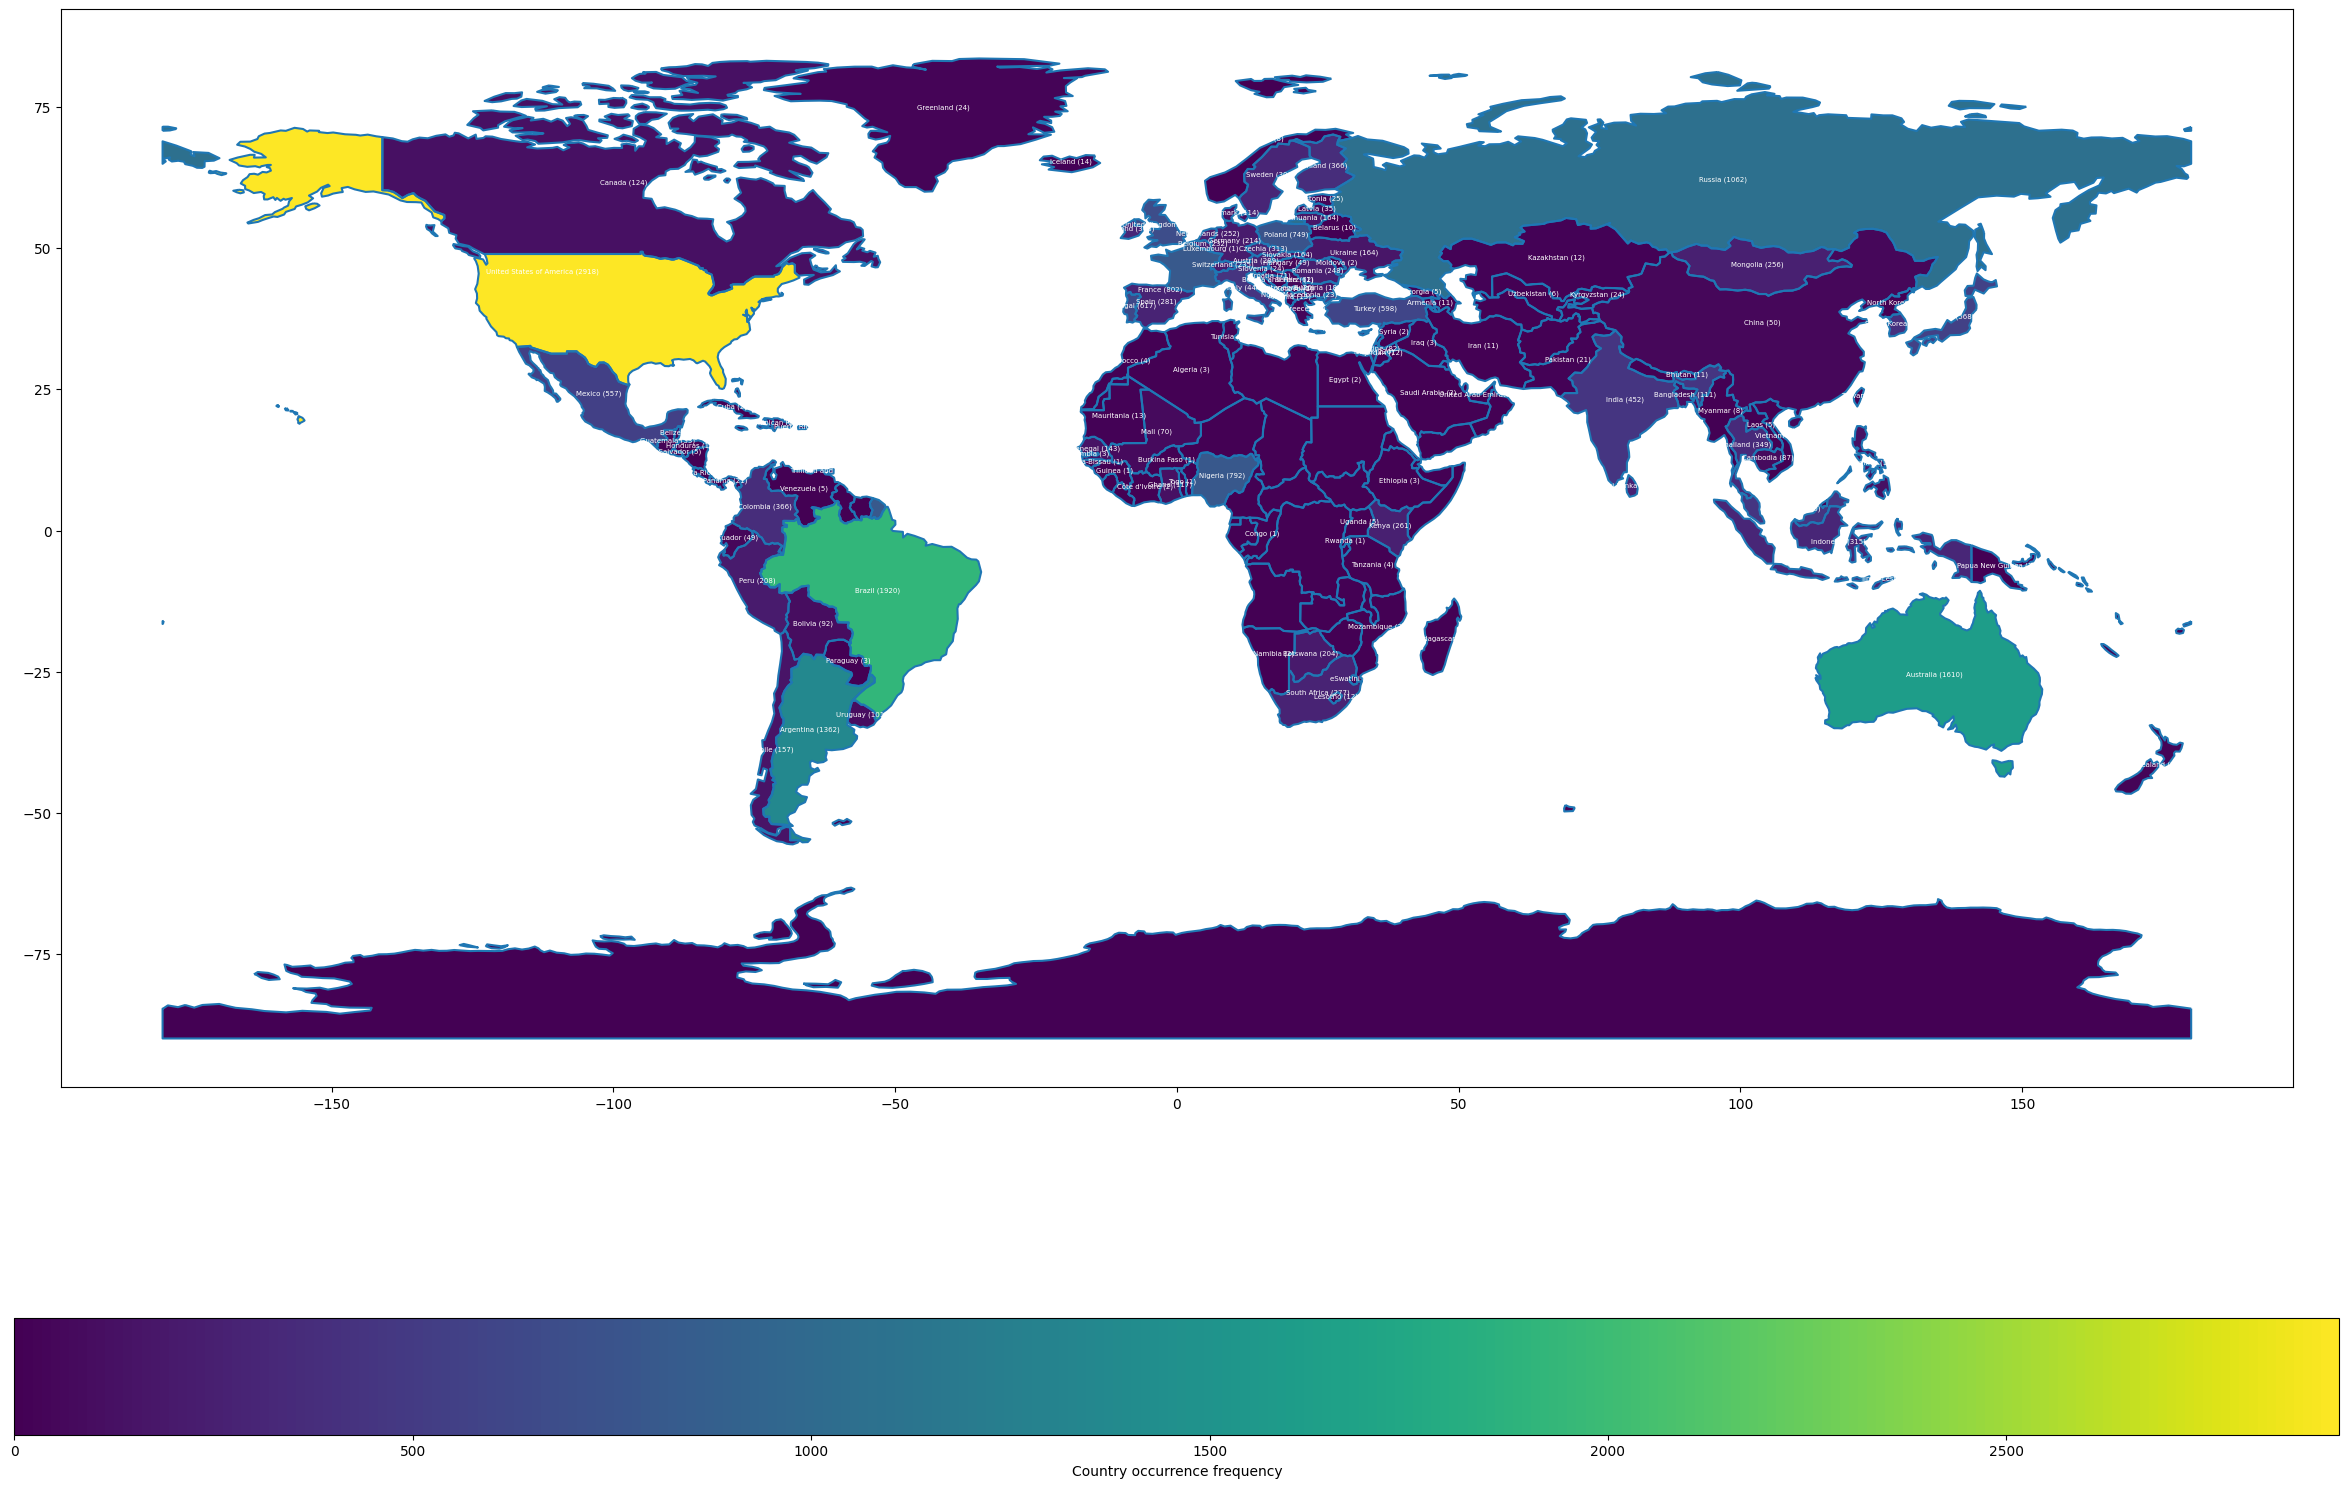

In [254]:
# count occurencies
country_counts = geo_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# join to world map
world = world.merge(country_counts, how='left', left_on='name', right_on='country')

# deal with na-s
world['count'] = world['count'].fillna(0)

# create map
fig, ax = plt.subplots(1, 1, figsize=(30, 20))
world.boundary.plot(ax=ax)
world.plot(column='count', ax=ax, legend=True, 
           legend_kwds={'label': "Country occurrence frequency",
                        'orientation': "horizontal"})

# country names and occurencies
for idx, row in world.iterrows():
    if row['count'] > 0:
        plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
                 f"{row['name']} ({int(row['count'])})", 
                 horizontalalignment='center', fontsize=5, color='white')

plt.show()

C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\1089660328.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


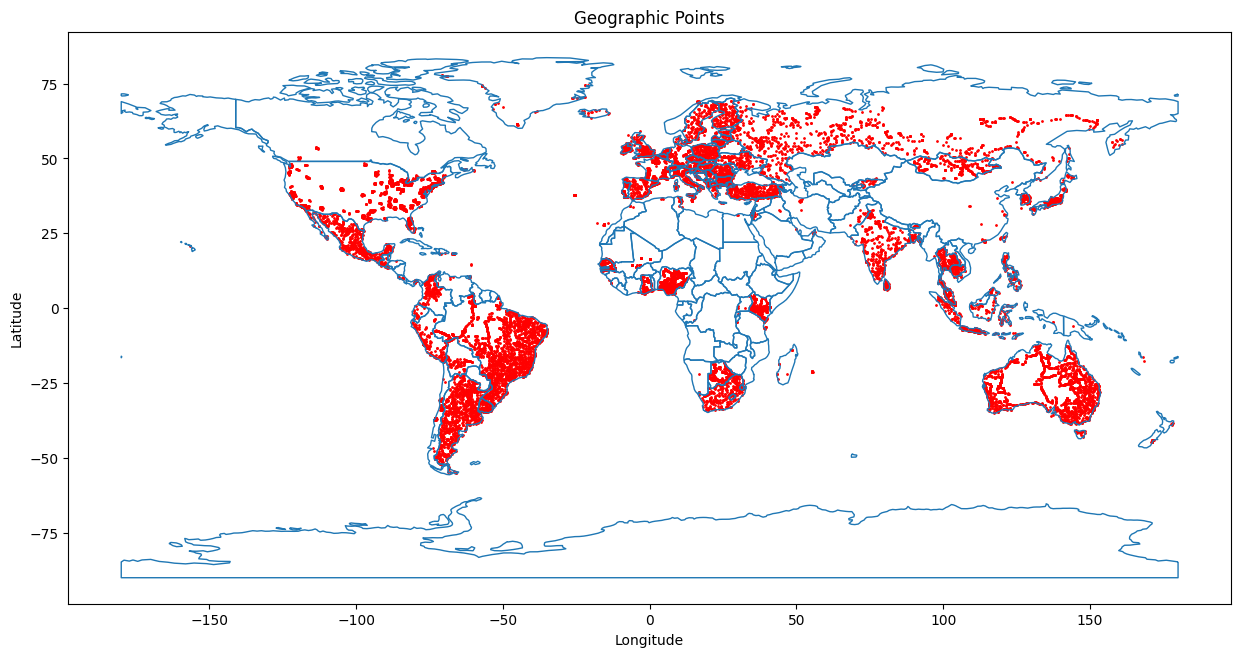

In [257]:
# create a geodf
geometry = [Point(xy) for xy in zip(geo_df['longitude'], geo_df['latitude'])]
gdf = gpd.GeoDataFrame(geo_df, geometry=geometry)

# set coordinates
gdf.set_crs(epsg=4326, inplace=True)

# plot places of pictures
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plot map
fig, ax = plt.subplots(figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, color='red', markersize=1)

plt.title('Geographic Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [258]:
# reset index for finding pictures
geo_df = geo_df.reset_index()

C:\Users\Márk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\1418372158.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


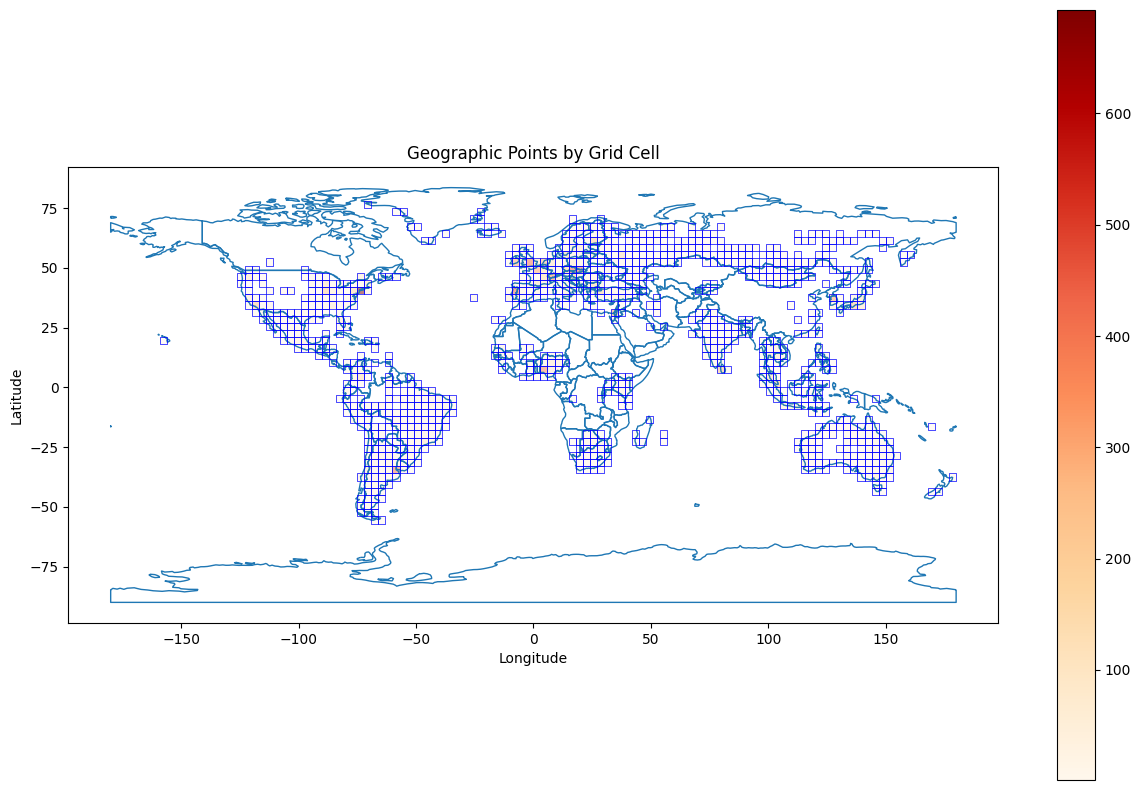

                                               geometry  point_count
2143  POLYGON ((-72.00000 39.00000, -72.00000 42.000...        693.0
3946  POLYGON ((18.00000 48.00000, 18.00000 51.00000...        451.0
3463  POLYGON ((-6.00000 39.00000, -6.00000 42.00000...        439.0
4006  POLYGON ((21.00000 48.00000, 21.00000 51.00000...        431.0
3587  POLYGON ((0.00000 51.00000, 0.00000 54.00000, ...        419.0
...                                                 ...          ...
4543  POLYGON ((48.00000 39.00000, 48.00000 42.00000...          1.0
4601  POLYGON ((51.00000 33.00000, 51.00000 36.00000...          1.0
4605  POLYGON ((51.00000 45.00000, 51.00000 48.00000...          1.0
4609  POLYGON ((51.00000 57.00000, 51.00000 60.00000...          1.0
456   POLYGON ((-156.00000 18.00000, -156.00000 21.0...          1.0

[969 rows x 2 columns]


In [259]:
# define grid size
grid_size = 3.0

# create grids on world
xmin, ymin, xmax, ymax = -180.0, -90.0, 180.0, 90.0
cols = np.arange(xmin, xmax + grid_size, grid_size)
rows = np.arange(ymin, ymax + grid_size, grid_size)
polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polygons})
grid.set_crs(epsg=4326, inplace=True)

# spatial join points with grids
joined = gpd.sjoin(gdf, grid, how='left', op='within')

# count points in grid cells
grid['point_count'] = joined.groupby('index_right').size()
grid['point_count'] = grid['point_count'].fillna(0)

# filter grids without points
grid_nonzero = grid[grid['point_count'] > 0]

# plot world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
grid_nonzero.boundary.plot(ax=ax, color='blue', linewidth=0.5)
grid_nonzero.plot(column='point_count', ax=ax, legend=True, cmap='OrRd', markersize=1, alpha=0.5)

plt.title('Geographic Points by Grid Cell')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# list grid cells
grid_list = grid_nonzero[['geometry', 'point_count']].sort_values(by='point_count', ascending=False)
print(grid_list)


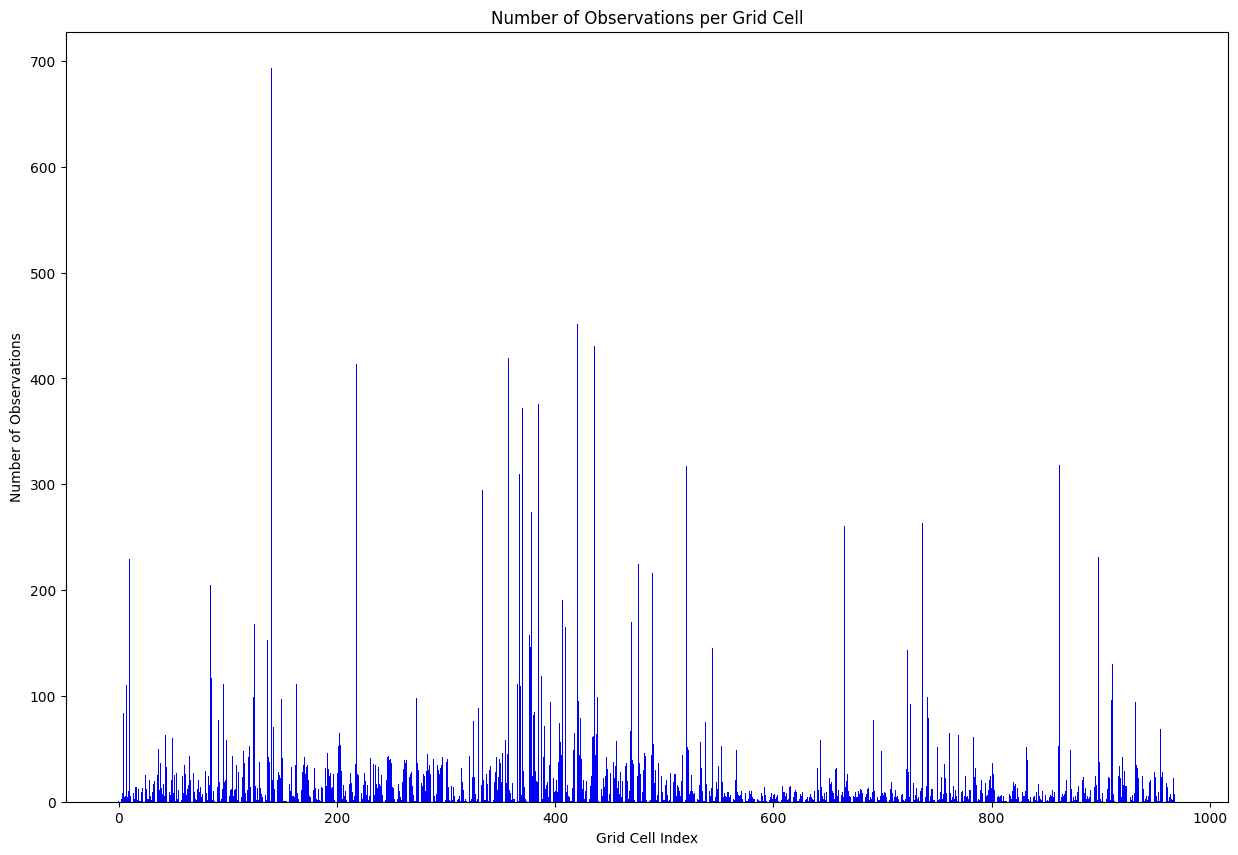

In [261]:
import matplotlib.pyplot as plt

# count points in grids
counts = grid_nonzero['point_count'].values

# create bar plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(range(len(counts)), counts, color='blue')

plt.title('Number of Observations per Grid Cell')
plt.xlabel('Grid Cell Index')
plt.ylabel('Number of Observations')
plt.show()


In [262]:
# create grids
xmin, ymin, xmax, ymax = -180.0, -90.0, 180.0, 90.0
cols = np.arange(xmin, xmax + grid_size, grid_size)
rows = np.arange(ymin, ymax + grid_size, grid_size)
polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(box(x, y, x + grid_size, y + grid_size))

grid = gpd.GeoDataFrame({'geometry': polygons})
grid.set_crs(epsg=4326, inplace=True)

# spatial match
joined = gpd.sjoin(gdf, grid, how='left', op='within')

# add grid_id
gdf['grid_id'] = joined['index_right']
gdf = gdf.merge(grid.reset_index(), left_on='grid_id', right_on='index', suffixes=('', '_grid'))

        longitude   latitude  grid_id  \
0      -98.499517  20.824885   1656.0   
1      -54.563937  -3.451752   2488.0   
2      -47.460542 -23.496464   2662.0   
3      -72.852778 -16.548678   2124.0   
4      140.064397 -35.010870   6378.0   
...           ...        ...      ...   
25222  121.014760  14.564200   6034.0   
25223  122.863700   9.333700   6033.0   
25224  121.309490  14.485150   6034.0   
25225  120.710720  16.412400   6035.0   
25226  -15.614820  13.638550   3274.0   

                                           geometry_grid  
0      POLYGON ((-96.00000 18.00000, -96.00000 21.000...  
1      POLYGON ((-54.00000 -6.00000, -54.00000 -3.000...  
2      POLYGON ((-45.00000 -24.00000, -45.00000 -21.0...  
3      POLYGON ((-72.00000 -18.00000, -72.00000 -15.0...  
4      POLYGON ((141.00000 -36.00000, 141.00000 -33.0...  
...                                                  ...  
25222  POLYGON ((123.00000 12.00000, 123.00000 15.000...  
25223  POLYGON ((123.00000 9.00000,

C:\Users\Márk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [264]:
# making sure, that the grid_id categorical
gdf['grid_id'] = gdf['grid_id'].astype('category')

In [265]:
geo_df = gdf

In [266]:
# create unique ids
unique_geometry_grids = geo_df['geometry_grid'].unique()
new_ids = {geometry_grid: i for i, geometry_grid in enumerate(unique_geometry_grids)}

# create new grid_id
geo_df['grid_id'] = geo_df['geometry_grid'].map(new_ids)


Build model

6th try

In [269]:
# create file names in geo_df
geo_df['index'] = geo_df['index'].astype(str) + '.png'

In [276]:
# check if pictures exist in the directory
directory = 'Streetview_Image_Dataset'
geo_df['filepath'] = geo_df['index'].apply(lambda x: os.path.join(directory, x))
geo_df = geo_df[geo_df['filepath'].apply(os.path.exists)]

# grid_id to str
geo_df['grid_id_str'] = geo_df['grid_id'].astype(str)

# initialize datagenerator
datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=geo_df,
    directory=directory,
    x_col='index',
    y_col='grid_id_str',
    target_size=(640, 640),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=geo_df,
    directory=directory,
    x_col='index',
    y_col='grid_id_str',
    target_size=(640, 640),
    batch_size=50,
    class_mode='categorical',
    subset='validation'
)

# create resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(640, 640, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(geo_df['grid_id'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# only train upper layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.008), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# save after each epoch
checkpoint = ModelCheckpoint(
    filepath='resnet50_geoguessr_epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_freq='epoch'
)

# train model
history = model.fit(train_generator, validation_data=validation_generator, epochs=3, callbacks=[checkpoint])

Found 17659 validated image filenames belonging to 969 classes.
Found 7568 validated image filenames belonging to 969 classes.
Epoch 1/3


C:\Users\Márk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


552/552 ━━━━━━━━━━━━━━━━━━━━ 6972s 13s/step - accuracy: 0.0313 - loss: 6.8369 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.0033 - val_loss: 7.2923 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/3
552/552 ━━━━━━━━━━━━━━━━━━━━ 6648s 12s/step - accuracy: 0.0413 - loss: 5.4123 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 1.3214e-04 - val_loss: 8.3437 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/3
160/552 ━━━━━━━━━━━━━━━━━━━━ 59:38 9s/step - accuracy: 0.0431 - loss: 5.4317 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Checking filename: 9110.png
True class found: 327


C:\Users\Márk\AppData\Local\Temp\ipykernel_16236\4063867009.py:27: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


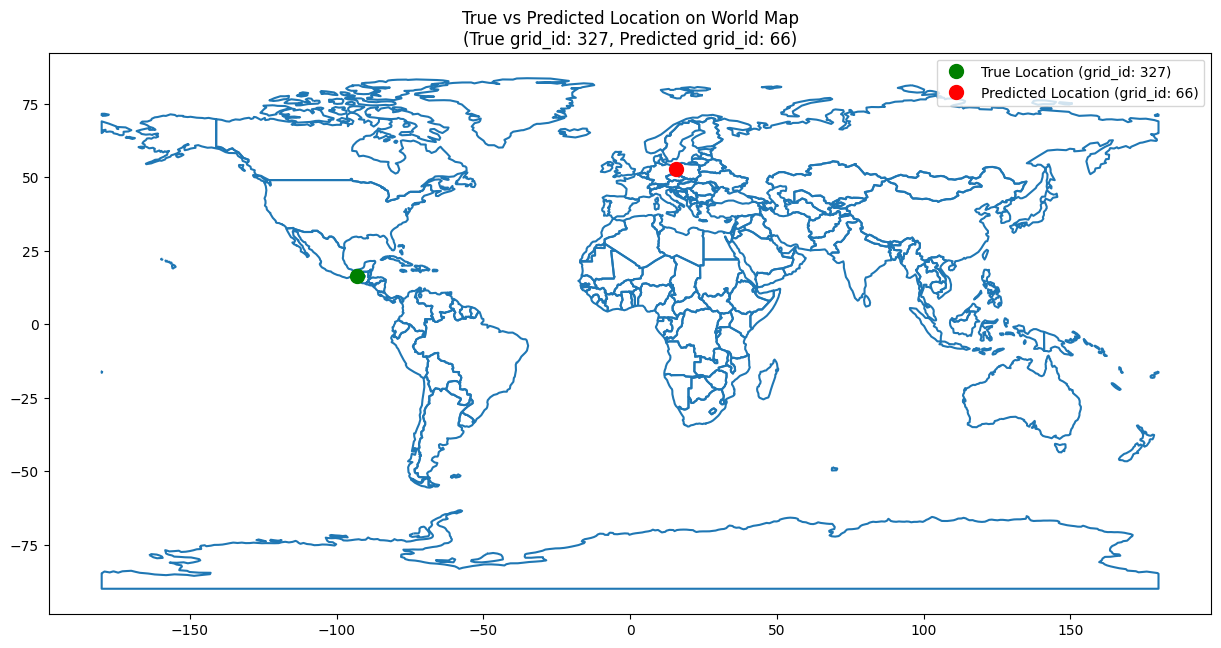

In [293]:
# load model
model = tf.keras.models.load_model('resnet50_geoguessr_epoch_04.keras')

# define test picture
test_image_path = './Streetview_Image_Dataset/9110.png'
test_image = load_img(test_image_path, target_size=(640, 640))
test_image_array = img_to_array(test_image) / 255.0
test_image_array = np.expand_dims(test_image_array, axis=0)

# create prediction
predicted_probabilities = model.predict(test_image_array)
predicted_class = np.argmax(predicted_probabilities, axis=1)[0]

# check if picture exist
filename = os.path.basename(test_image_path)#.replace('.png', '')
print(f"Checking filename: {filename}")

if filename in geo_df['index'].astype(str).values:
    true_class = geo_df[geo_df['index'].astype(str) == filename]['grid_id'].values[0]
    print(f"True class found: {true_class}")

    # true and predicted location
    true_location = geo_df[geo_df['grid_id'] == true_class][['latitude', 'longitude']].values[0]
    predicted_location = geo_df[geo_df['grid_id'] == predicted_class][['latitude', 'longitude']].values[0]

    # create world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.boundary.plot(ax=ax)

    # plot true location
    ax.plot(true_location[1], true_location[0], 'go', markersize=10, label=f'True Location (grid_id: {true_class})')

    # plot predicted location
    ax.plot(predicted_location[1], predicted_location[0], 'ro', markersize=10, label=f'Predicted Location (grid_id: {predicted_class})')

    # legend and title
    ax.legend()
    ax.set_title(f'True vs Predicted Location on World Map\n(True grid_id: {true_class}, Predicted grid_id: {predicted_class})')

    plt.show()
else:
    print(f"Filename {filename} not found in geo_df.")


Validation

In [309]:
# load the saved model
model_path = 'resnet50_geoguessr_epoch_04.keras'
model = load_model(model_path)

# check if pictures exist in the directory
directory = 'Streetview_Image_Dataset'
geo_df['filepath'] = geo_df['index'].apply(lambda x: os.path.join(directory, x))
geo_df = geo_df[geo_df['filepath'].apply(os.path.exists)]

# grid_id to str
geo_df['grid_id_str'] = geo_df['grid_id'].astype(str)

# initialize datagenerator
datagen = ImageDataGenerator(validation_split=0.3, rescale=1./255)

validation_generator = datagen.flow_from_dataframe(
    dataframe=geo_df,
    directory=directory,
    x_col='index',
    y_col='grid_id_str',
    target_size=(640, 640),
    batch_size=50,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 7568 validated image filenames belonging to 969 classes.


In [310]:
# get a subset of the validation data
subset_size = int(validation_generator.samples / 10)
x_val_subset, y_val_subset = [], []

# collect the subset
for i in range(subset_size // validation_generator.batch_size):
    x_batch, y_batch = next(validation_generator)
    x_val_subset.append(x_batch)
    y_val_subset.append(y_batch)

x_val_subset = np.vstack(x_val_subset)
y_val_subset = np.vstack(y_val_subset)

# evaluate the model
scores = model.evaluate(x_val_subset, y_val_subset)
print(f'Loss: {scores[0]}, Accuracy: {scores[1]}, Precision: {scores[2]}, Recall: {scores[3]}')


24/24 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.0000e+00 - loss: 7.8027 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Loss: 7.943637847900391, Accuracy: 0.0, Precision: 0.0, Recall: 0.0


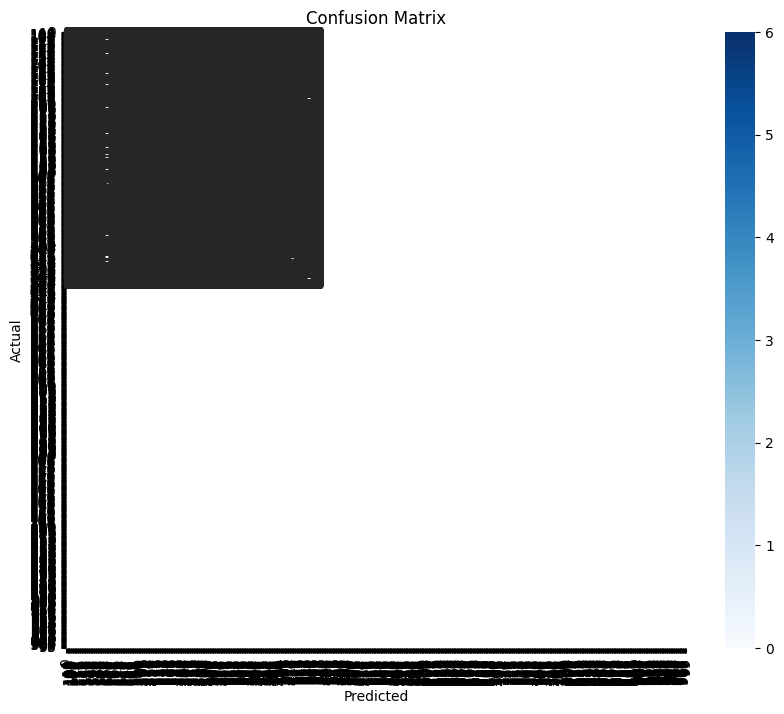

In [312]:
# predict on validation subset
Y_pred = model.predict(x_val_subset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_val_subset, axis=1)

# classification report
class_labels = list(validation_generator.class_indices.keys())   


# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()